# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 64  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"]/5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 118453.578125
iteration 0 loss 97946.3046875


iteration 500 loss 368.9408874511719


iteration 1000 loss 322.09375


iteration 1500 loss 287.43804931640625


iteration 2000 loss 259.67425537109375


iteration 2500 loss 234.0128173828125


iteration 3000 loss 203.0999298095703


iteration 3500 loss 148.3938751220703


iteration 4000 loss 75.91238403320312


iteration 4500 loss 33.45111846923828


iteration 5000 loss 30.625917434692383


iteration 5500 loss 13.416119575500488


iteration 6000 loss 9.454527854919434


iteration 6500 loss 6.84808874130249


iteration 7000 loss 10.084792137145996


iteration 7500 loss 5.371581077575684


iteration 8000 loss 4.278226852416992


iteration 8500 loss 3.485584259033203


iteration 9000 loss 2.8145751953125


iteration 9500 loss 2.79868221282959


iteration 10000 loss 2.3166096210479736


iteration 10500 loss 1.9472347497940063


iteration 11000 loss 3.0002987384796143


iteration 11500 loss 2.07314133644104


iteration 12000 loss 1.7358355522155762


iteration 12500 loss 1.4954373836517334


iteration 13000 loss 16.6019287109375


iteration 13500 loss 1.557138442993164


iteration 14000 loss 1.2800076007843018


iteration 14500 loss 1.11251699924469


iteration 15000 loss 1.744873046875


iteration 15500 loss 1.0620043277740479


iteration 16000 loss 0.9170777797698975


iteration 16500 loss 1.8053642511367798


iteration 17000 loss 0.946291983127594


iteration 17500 loss 0.8063198924064636


iteration 18000 loss 0.7155893445014954


iteration 18500 loss 0.7497631311416626


iteration 19000 loss 0.6460287570953369


iteration 19500 loss 0.697401762008667


iteration 20000 loss 0.5912684202194214


iteration 20500 loss 0.7662717700004578


iteration 21000 loss 0.5697559714317322


iteration 21500 loss 0.5085763335227966


iteration 22000 loss 0.5583102107048035


iteration 22500 loss 0.4741937518119812


iteration 23000 loss 0.6899157166481018


iteration 23500 loss 0.4809055030345917


iteration 24000 loss 0.4202420711517334


iteration 24500 loss 0.4528307616710663


iteration 25000 loss 0.38480740785598755


iteration 25500 loss 0.45019394159317017


iteration 26000 loss 0.37081414461135864


iteration 26500 loss 0.46600788831710815


iteration 27000 loss 0.3474670946598053


iteration 27500 loss 0.4191123843193054


iteration 28000 loss 0.321856290102005


iteration 28500 loss 0.3421759605407715


iteration 29000 loss 0.3382194936275482


iteration 29500 loss 0.2932926416397095


iteration 30000 loss 0.29715433716773987


iteration 30500 loss 0.3913395404815674


iteration 31000 loss 0.26257508993148804


iteration 31500 loss 0.25331738591194153


iteration 32000 loss 0.26529568433761597


iteration 32500 loss 0.29442957043647766


iteration 33000 loss 0.2311726063489914


iteration 33500 loss 0.23427744209766388


iteration 34000 loss 0.23540112376213074


iteration 34500 loss 0.2900412082672119


iteration 35000 loss 0.20718663930892944


iteration 35500 loss 0.21131546795368195


iteration 36000 loss 0.2472400814294815


iteration 36500 loss 0.1914975792169571


iteration 37000 loss 0.19118385016918182


iteration 37500 loss 0.18552888929843903


iteration 38000 loss 0.18246345221996307


iteration 38500 loss 0.17498339712619781


iteration 39000 loss 0.16908039152622223


iteration 39500 loss 0.16627341508865356


iteration 40000 loss 0.4811345636844635


iteration 40500 loss 0.6132408976554871


iteration 41000 loss 0.47063061594963074


iteration 41500 loss 26.979873657226562


iteration 42000 loss 19.57748031616211


iteration 42500 loss 0.2014651596546173


iteration 43000 loss 0.18242044746875763


iteration 43500 loss 0.1849559247493744


iteration 44000 loss 0.17109443247318268


iteration 44500 loss 0.17000356316566467


iteration 45000 loss 0.1829683929681778


iteration 45500 loss 0.16602985560894012


iteration 46000 loss 0.13784170150756836


iteration 46500 loss 0.13269338011741638


iteration 47000 loss 0.12687259912490845


iteration 47500 loss 0.12387505918741226


iteration 48000 loss 0.11835239827632904


iteration 48500 loss 0.1174006462097168


iteration 49000 loss 0.11625710129737854


iteration 49500 loss 0.12425719946622849


iteration 50000 loss 0.11393298953771591


iteration 50500 loss 0.20355042815208435


iteration 51000 loss 0.1315724402666092


iteration 51500 loss 0.1129746288061142


iteration 52000 loss 0.10443935543298721


iteration 52500 loss 0.18217909336090088


iteration 53000 loss 0.11254487186670303


iteration 53500 loss 2.2787249088287354


iteration 54000 loss 0.10254243016242981


iteration 54500 loss 0.4935511648654938


iteration 55000 loss 0.12979909777641296


iteration 55500 loss 0.09882128983736038


iteration 56000 loss 0.09479404985904694


iteration 56500 loss 0.08959546685218811


iteration 57000 loss 29.59737205505371


iteration 57500 loss 0.10170887410640717


iteration 58000 loss 0.08978068083524704


iteration 58500 loss 0.4047684371471405


iteration 59000 loss 2.0957400798797607


iteration 59500 loss 0.10471897572278976


iteration 60000 loss 0.09718184918165207


iteration 60500 loss 0.08566653728485107


iteration 61000 loss 0.14494898915290833


iteration 61500 loss 0.09102091193199158


iteration 62000 loss 0.08205743879079819


iteration 62500 loss 59.207984924316406


iteration 63000 loss 0.0761328935623169


iteration 63500 loss 0.07971600443124771


iteration 64000 loss 11.6668119430542


iteration 64500 loss 0.07770229130983353


iteration 65000 loss 0.2143547236919403


iteration 65500 loss 0.07138609141111374


iteration 66000 loss 0.08402994275093079


iteration 66500 loss 0.07239602506160736


iteration 67000 loss 0.06960081309080124


iteration 67500 loss 0.06935618817806244


iteration 68000 loss 0.06677454710006714


iteration 68500 loss 0.06911475211381912


iteration 69000 loss 0.08149667829275131


iteration 69500 loss 0.06532474607229233


iteration 70000 loss 0.0698084756731987


iteration 70500 loss 0.09772291779518127


iteration 71000 loss 0.08067256212234497


iteration 71500 loss 0.06466267257928848


iteration 72000 loss 1.6834913492202759


iteration 72500 loss 0.06662014871835709


iteration 73000 loss 0.10570017993450165


iteration 73500 loss 2.053300619125366


iteration 74000 loss 4.305310249328613


iteration 74500 loss 0.20262287557125092


iteration 75000 loss 4.288639068603516


iteration 75500 loss 0.7310243248939514


iteration 76000 loss 0.184173122048378


iteration 76500 loss 7.023432731628418


iteration 77000 loss 4.529341697692871


iteration 77500 loss 0.08060244470834732


iteration 78000 loss 0.09026411920785904


iteration 78500 loss 2.4307868480682373


iteration 79000 loss 8.77785873413086


iteration 79500 loss 0.06248285993933678


iteration 80000 loss 0.1265031397342682


iteration 80500 loss 1.2329638004302979


iteration 81000 loss 9.967436790466309


iteration 81500 loss 2.6605331897735596


iteration 82000 loss 0.11771635711193085


iteration 82500 loss 0.11310677230358124


iteration 83000 loss 0.10177821666002274


iteration 83500 loss 0.4674170911312103


iteration 84000 loss 0.31688740849494934


iteration 84500 loss 0.19666925072669983


iteration 85000 loss 0.06545376777648926


iteration 85500 loss 0.21453911066055298


iteration 86000 loss 0.2388962358236313


iteration 86500 loss 0.051164411008358


iteration 87000 loss 0.3317176103591919


iteration 87500 loss 0.1931440383195877


iteration 88000 loss 0.4622862637042999


iteration 88500 loss 5.4260125160217285


iteration 89000 loss 1.874537467956543


iteration 89500 loss 9.193123817443848


iteration 90000 loss 0.21376876533031464


iteration 90500 loss 0.9671370983123779


iteration 91000 loss 7.673796653747559


iteration 91500 loss 0.18655915558338165


iteration 92000 loss 4.701706409454346


iteration 92500 loss 0.278775691986084


iteration 93000 loss 7.864534378051758


iteration 93500 loss 1.33077871799469


iteration 94000 loss 1.6786714792251587


iteration 94500 loss 0.055808115750551224


iteration 95000 loss 1.4710391759872437


iteration 95500 loss 0.2229575365781784


iteration 96000 loss 0.27098533511161804


iteration 96500 loss 0.35393595695495605


iteration 97000 loss 0.3048763573169708


iteration 97500 loss 1.043458342552185


iteration 98000 loss 6.32197904586792


iteration 98500 loss 0.043978553265333176


iteration 99000 loss 0.5716856718063354


iteration 99500 loss 0.0836801528930664


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 1.0829846858978271


iteration 100500 loss 0.034516919404268265


iteration 101000 loss 0.03246600553393364


iteration 101500 loss 0.030913883820176125


iteration 102000 loss 0.029528314247727394


iteration 102500 loss 0.02820923924446106


iteration 103000 loss 0.026905303820967674


iteration 103500 loss 0.0414908304810524


iteration 104000 loss 0.02481858804821968


iteration 104500 loss 0.023997653275728226


iteration 105000 loss 0.023920023813843727


iteration 105500 loss 0.02276788279414177


iteration 106000 loss 0.022255560383200645


iteration 106500 loss 0.02124781534075737


iteration 107000 loss 0.020663585513830185


iteration 107500 loss 0.02012862265110016


iteration 108000 loss 0.019864702597260475


iteration 108500 loss 0.020800571888685226


iteration 109000 loss 0.02975069172680378


iteration 109500 loss 0.01872248575091362


iteration 110000 loss 0.027539800852537155


iteration 110500 loss 0.017533104866743088


iteration 111000 loss 0.017154010012745857


iteration 111500 loss 0.016788531094789505


iteration 112000 loss 0.016494659706950188


iteration 112500 loss 0.016876637935638428


iteration 113000 loss 0.022373711690306664


iteration 113500 loss 0.015739332884550095


iteration 114000 loss 0.015181167051196098


iteration 114500 loss 0.014872613362967968


iteration 115000 loss 0.014572500251233578


iteration 115500 loss 0.014325842261314392


iteration 116000 loss 0.014033342711627483


iteration 116500 loss 0.013843429274857044


iteration 117000 loss 0.01668599806725979


iteration 117500 loss 0.014334353618323803


iteration 118000 loss 0.013019404374063015


iteration 118500 loss 0.09481001645326614


iteration 119000 loss 0.012609411031007767


iteration 119500 loss 0.01244266889989376


iteration 120000 loss 0.016989827156066895


iteration 120500 loss 0.011908436194062233


iteration 121000 loss 0.018430162221193314


iteration 121500 loss 0.011503889225423336


iteration 122000 loss 0.011304426938295364


iteration 122500 loss 0.014863799326121807


iteration 123000 loss 0.014420534484088421


iteration 123500 loss 0.010730904527008533


iteration 124000 loss 0.014889417216181755


iteration 124500 loss 2.516071081161499


iteration 125000 loss 0.011247163638472557


iteration 125500 loss 0.010072631761431694


iteration 126000 loss 0.015053032897412777


iteration 126500 loss 0.010116498917341232


iteration 127000 loss 0.009585065767168999


iteration 127500 loss 0.009406881406903267


iteration 128000 loss 0.45186561346054077


iteration 128500 loss 0.009270807728171349


iteration 129000 loss 0.008986334316432476


iteration 129500 loss 0.008886253461241722


iteration 130000 loss 0.008761607110500336


iteration 130500 loss 0.04648261517286301


iteration 131000 loss 0.008458294905722141


iteration 131500 loss 0.008300907909870148


iteration 132000 loss 0.008171294815838337


iteration 132500 loss 0.1553679257631302


iteration 133000 loss 0.007958746515214443


iteration 133500 loss 0.007810748182237148


iteration 134000 loss 0.007813558913767338


iteration 134500 loss 0.14596393704414368


iteration 135000 loss 0.008307977579534054


iteration 135500 loss 0.017273709177970886


iteration 136000 loss 0.007327080238610506


iteration 136500 loss 0.007196501828730106


iteration 137000 loss 0.007087633945047855


iteration 137500 loss 0.006976246368139982


iteration 138000 loss 0.006910061463713646


iteration 138500 loss 0.00683646509423852


iteration 139000 loss 0.006623605731874704


iteration 139500 loss 0.006703311111778021


iteration 140000 loss 0.02355349436402321


iteration 140500 loss 0.02323981560766697


iteration 141000 loss 0.006241524126380682


iteration 141500 loss 0.006210963241755962


iteration 142000 loss 0.006094618234783411


iteration 142500 loss 0.005974705331027508


iteration 143000 loss 0.00590855535119772


iteration 143500 loss 0.005816262681037188


iteration 144000 loss 0.007197941187769175


iteration 144500 loss 0.01220319140702486


iteration 145000 loss 0.005570903420448303


iteration 145500 loss 0.005528587847948074


iteration 146000 loss 0.021013954654335976


iteration 146500 loss 0.08901776373386383


iteration 147000 loss 0.005253415554761887


iteration 147500 loss 0.005237463861703873


iteration 148000 loss 0.044814709573984146


iteration 148500 loss 1.2905116081237793


iteration 149000 loss 0.005010086577385664


iteration 149500 loss 0.005234920419752598


iteration 150000 loss 0.004862594418227673


iteration 150500 loss 0.004814429208636284


iteration 151000 loss 0.038397129625082016


iteration 151500 loss 0.005445276387035847


iteration 152000 loss 0.004609704948961735


iteration 152500 loss 0.004571910947561264


iteration 153000 loss 0.34423699975013733


iteration 153500 loss 0.004404004197567701


iteration 154000 loss 0.004466199316084385


iteration 154500 loss 0.24304364621639252


iteration 155000 loss 0.43269094824790955


iteration 155500 loss 0.03399742767214775


iteration 156000 loss 0.0041345045901834965


iteration 156500 loss 0.004098527133464813


iteration 157000 loss 0.026705598458647728


iteration 157500 loss 0.003964878618717194


iteration 158000 loss 0.006996297277510166


iteration 158500 loss 0.0038624885492026806


iteration 159000 loss 0.0038874270394444466


iteration 159500 loss 0.017173605039715767


iteration 160000 loss 0.004027997143566608


iteration 160500 loss 0.003674275940284133


iteration 161000 loss 0.0036401236429810524


iteration 161500 loss 0.022204943001270294


iteration 162000 loss 0.0035702369641512632


iteration 162500 loss 0.003594126319512725


iteration 163000 loss 0.0034362769220024347


iteration 163500 loss 0.0042020478285849094


iteration 164000 loss 0.09970862418413162


iteration 164500 loss 0.0033643916249275208


iteration 165000 loss 0.0032850257121026516


iteration 165500 loss 0.029932377859950066


iteration 166000 loss 0.003196496982127428


iteration 166500 loss 0.0031795252580195665


iteration 167000 loss 0.868891179561615


iteration 167500 loss 0.5608490705490112


iteration 168000 loss 0.0030495752580463886


iteration 168500 loss 0.054020628333091736


iteration 169000 loss 0.0029795051086694


iteration 169500 loss 0.0029442349914461374


iteration 170000 loss 0.003196025500074029


iteration 170500 loss 0.002905759261921048


iteration 171000 loss 0.0028340639546513557


iteration 171500 loss 0.002806982956826687


iteration 172000 loss 0.002838290296494961


iteration 172500 loss 0.0033124855253845453


iteration 173000 loss 0.0027611751575022936


iteration 173500 loss 0.0030446723103523254


iteration 174000 loss 0.040439680218696594


iteration 174500 loss 0.09713244438171387


iteration 175000 loss 0.0656711533665657


iteration 175500 loss 0.010925358161330223


iteration 176000 loss 0.009116245433688164


iteration 176500 loss 0.07428738474845886


iteration 177000 loss 0.12011884152889252


iteration 177500 loss 0.2543049156665802


iteration 178000 loss 0.05122056603431702


iteration 178500 loss 0.10397761315107346


iteration 179000 loss 0.004556060768663883


iteration 179500 loss 0.004098287783563137


iteration 180000 loss 0.15528413653373718


iteration 180500 loss 0.04095768183469772


iteration 181000 loss 0.002236984670162201


iteration 181500 loss 0.00329651334322989


iteration 182000 loss 0.03403647243976593


iteration 182500 loss 0.12878312170505524


iteration 183000 loss 0.11746668070554733


iteration 183500 loss 0.0031517143361270428


iteration 184000 loss 0.009867279790341854


iteration 184500 loss 0.03251032531261444


iteration 185000 loss 0.010291336104273796


iteration 185500 loss 0.19075194001197815


iteration 186000 loss 0.08823360502719879


iteration 186500 loss 0.08710717409849167


iteration 187000 loss 0.05034293234348297


iteration 187500 loss 0.030705880373716354


iteration 188000 loss 0.09349045157432556


iteration 188500 loss 0.08990016579627991


iteration 189000 loss 0.10608966648578644


iteration 189500 loss 0.3015040159225464


iteration 190000 loss 0.11714843660593033


iteration 190500 loss 0.09953109920024872


iteration 191000 loss 0.034909650683403015


iteration 191500 loss 0.022481268271803856


iteration 192000 loss 0.13029666244983673


iteration 192500 loss 0.06027297303080559


iteration 193000 loss 0.009268893860280514


iteration 193500 loss 0.002596830716356635


iteration 194000 loss 0.01653357595205307


iteration 194500 loss 0.04776650667190552


iteration 195000 loss 0.06581740826368332


iteration 195500 loss 0.17586678266525269


iteration 196000 loss 0.16949822008609772


iteration 196500 loss 0.0585402213037014


iteration 197000 loss 0.010190307162702084


iteration 197500 loss 0.15218301117420197


iteration 198000 loss 0.04179006069898605


iteration 198500 loss 0.002678085584193468


iteration 199000 loss 0.001990952994674444


iteration 199500 loss 0.00438344432041049


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.0014743867795914412


iteration 200500 loss 0.001422600937075913


iteration 201000 loss 0.0014132868964225054


iteration 201500 loss 0.001403996255248785


iteration 202000 loss 0.0013933797599747777


iteration 202500 loss 0.0013806871138513088


iteration 203000 loss 0.0013652703491970897


iteration 203500 loss 0.002717586001381278


iteration 204000 loss 0.0013327060732990503


iteration 204500 loss 0.0013202247209846973


iteration 205000 loss 0.0023294396232813597


iteration 205500 loss 0.001284174039028585


iteration 206000 loss 0.001268906518816948


iteration 206500 loss 0.0012543187476694584


iteration 207000 loss 0.0012417020043358207


iteration 207500 loss 0.002340356120839715


iteration 208000 loss 0.030242083594202995


iteration 208500 loss 0.0014184798346832395


iteration 209000 loss 0.0011815950274467468


iteration 209500 loss 0.0011695092543959618


iteration 210000 loss 0.001294609042815864


iteration 210500 loss 0.0012258756905794144


iteration 211000 loss 0.001127938274294138


iteration 211500 loss 0.001116519677452743


iteration 212000 loss 0.001105668256059289


iteration 212500 loss 0.0013652564957737923


iteration 213000 loss 0.0010788916843011975


iteration 213500 loss 0.001064404146745801


iteration 214000 loss 0.001052712555974722


iteration 214500 loss 0.0010562660172581673


iteration 215000 loss 0.0010319664143025875


iteration 215500 loss 0.0010192864574491978


iteration 216000 loss 0.021353308111429214


iteration 216500 loss 0.021611515432596207


iteration 217000 loss 0.0009834583615884185


iteration 217500 loss 0.0009792584460228682


iteration 218000 loss 0.0009627091349102557


iteration 218500 loss 0.000976753537543118


iteration 219000 loss 0.0009408487239852548


iteration 219500 loss 0.0009336398798041046


iteration 220000 loss 0.0018587808590382338


iteration 220500 loss 0.0009564870852045715


iteration 221000 loss 0.0008982629515230656


iteration 221500 loss 0.0008890960598364472


iteration 222000 loss 0.000880399311427027


iteration 222500 loss 0.0008740760385990143


iteration 223000 loss 0.0010407132795080543


iteration 223500 loss 0.0017794700106605887


iteration 224000 loss 0.0008527475874871016


iteration 224500 loss 0.000830079719889909


iteration 225000 loss 0.0008210235391743481


iteration 225500 loss 0.0008204406476579607


iteration 226000 loss 0.0010967693524435163


iteration 226500 loss 0.0007938413764350116


iteration 227000 loss 0.0007865139632485807


iteration 227500 loss 0.000779980153311044


iteration 228000 loss 0.0007708402699790895


iteration 228500 loss 0.0007623943383805454


iteration 229000 loss 0.0008059014216996729


iteration 229500 loss 0.0007533702882938087


iteration 230000 loss 0.0007990800077095628


iteration 230500 loss 0.0007818911108188331


iteration 231000 loss 0.0009627353283576667


iteration 231500 loss 0.0015219220658764243


iteration 232000 loss 0.0007055861060507596


iteration 232500 loss 0.0007008863030932844


iteration 233000 loss 0.0006867924239486456


iteration 233500 loss 0.0006788303726352751


iteration 234000 loss 0.0006739234668202698


iteration 234500 loss 0.0008281983900815248


iteration 235000 loss 0.0007264197338372469


iteration 235500 loss 0.000650541391223669


iteration 236000 loss 0.0006443041493184865


iteration 236500 loss 0.000638980942312628


iteration 237000 loss 0.004442709032446146


iteration 237500 loss 0.0012543925549834967


iteration 238000 loss 0.0006166414823383093


iteration 238500 loss 0.0006184549420140684


iteration 239000 loss 0.0006017490522935987


iteration 239500 loss 0.0005946088931523263


iteration 240000 loss 0.000589195522479713


iteration 240500 loss 0.0005822649109177291


iteration 241000 loss 0.0007259766571223736


iteration 241500 loss 0.0005727903917431831


iteration 242000 loss 0.0005968561745248735


iteration 242500 loss 0.0005568585474975407


iteration 243000 loss 0.0005509376060217619


iteration 243500 loss 0.0005445602582767606


iteration 244000 loss 0.0005389695870690048


iteration 244500 loss 0.0005333925946615636


iteration 245000 loss 0.0005274325958453119


iteration 245500 loss 0.0005219518789090216


iteration 246000 loss 0.0005186427151784301


iteration 246500 loss 0.0005478888633660972


iteration 247000 loss 0.0005054393550381064


iteration 247500 loss 0.0004999967641197145


iteration 248000 loss 0.0004943003295920789


iteration 248500 loss 0.0004898099577985704


iteration 249000 loss 0.0004843739443458617


iteration 249500 loss 0.00048061631969176233


iteration 250000 loss 0.00047562678810209036


iteration 250500 loss 0.0004712385998573154


iteration 251000 loss 0.0004656911769416183


iteration 251500 loss 0.00046065301285125315


iteration 252000 loss 0.0004647278692573309


iteration 252500 loss 0.00045081047574058175


iteration 253000 loss 0.0004769378574565053


iteration 253500 loss 0.00043971327249892056


iteration 254000 loss 0.00043439300497993827


iteration 254500 loss 0.00043098244350403547


iteration 255000 loss 0.00043032277608290315


iteration 255500 loss 0.0004424529033713043


iteration 256000 loss 0.0004179771349299699


iteration 256500 loss 0.0004211722407490015


iteration 257000 loss 0.0004114251059945673


iteration 257500 loss 0.0006678773206658661


iteration 258000 loss 0.00762456189841032


iteration 258500 loss 0.00728970393538475


iteration 259000 loss 0.0730181559920311


iteration 259500 loss 0.009901902638375759


iteration 260000 loss 0.0007613291381858289


iteration 260500 loss 0.0004084416723344475


iteration 261000 loss 0.00037439787411130965


iteration 261500 loss 0.00037150047137402


iteration 262000 loss 0.0003667993878480047


iteration 262500 loss 0.0003651330480352044


iteration 263000 loss 0.0005812087911181152


iteration 263500 loss 0.0019547336269170046


iteration 264000 loss 0.00036884512519463897


iteration 264500 loss 0.0005828985595144331


iteration 265000 loss 0.000344739732099697


iteration 265500 loss 0.0003410005883779377


iteration 266000 loss 0.00033644516952335835


iteration 266500 loss 0.0009849357884377241


iteration 267000 loss 0.0029921806417405605


iteration 267500 loss 0.0003261402016505599


iteration 268000 loss 0.0003228826099075377


iteration 268500 loss 0.02421373501420021


iteration 269000 loss 0.012645385228097439


iteration 269500 loss 0.00031253654742613435


iteration 270000 loss 0.00034383570891804993


iteration 270500 loss 0.0003112259437330067


iteration 271000 loss 0.001210103160701692


iteration 271500 loss 0.0027419524267315865


iteration 272000 loss 0.0002961109858006239


iteration 272500 loss 0.0002945775049738586


iteration 273000 loss 0.00029011996230110526


iteration 273500 loss 0.0002883841807488352


iteration 274000 loss 0.0003059048030991107


iteration 274500 loss 0.00028254714561626315


iteration 275000 loss 0.0002783816889859736


iteration 275500 loss 0.00027560090529732406


iteration 276000 loss 0.0002736808964982629


iteration 276500 loss 0.00026953991618938744


iteration 277000 loss 0.00026871621957980096


iteration 277500 loss 0.0035396399907767773


iteration 278000 loss 0.0007863838109187782


iteration 278500 loss 0.00025800871662795544


iteration 279000 loss 0.00026121543487533927


iteration 279500 loss 0.0006296606152318418


iteration 280000 loss 0.00025222328258678317


iteration 280500 loss 0.003270181128755212


iteration 281000 loss 0.00024477599072270095


iteration 281500 loss 0.00024349834711756557


iteration 282000 loss 0.00024084116739686579


iteration 282500 loss 0.0002542355505283922


iteration 283000 loss 0.0003660506336018443


iteration 283500 loss 0.00031441025203093886


iteration 284000 loss 0.0002795318141579628


iteration 284500 loss 0.0003136303275823593


iteration 285000 loss 0.018704937770962715


iteration 285500 loss 0.0002245170035166666


iteration 286000 loss 0.00022124333190731704


iteration 286500 loss 0.00021854171063750982


iteration 287000 loss 0.00021626932721119374


iteration 287500 loss 0.00023005317780189216


iteration 288000 loss 0.06476063281297684


iteration 288500 loss 0.0002143093734048307


iteration 289000 loss 0.0004189656756352633


iteration 289500 loss 0.00021227473916951567


iteration 290000 loss 0.00020261983445379883


iteration 290500 loss 0.0002186234196415171


iteration 291000 loss 0.00031599635258316994


iteration 291500 loss 0.00020731796394102275


iteration 292000 loss 0.0001947373675648123


iteration 292500 loss 0.0001924563111970201


iteration 293000 loss 0.00019090175919700414


iteration 293500 loss 0.0001941345544764772


iteration 294000 loss 0.00018691510194912553


iteration 294500 loss 0.00018474477110430598


iteration 295000 loss 0.00018338464724365622


iteration 295500 loss 0.00018182682106271386


iteration 296000 loss 0.0001863061625044793


iteration 296500 loss 0.0002432684414088726


iteration 297000 loss 0.0003772360214497894


iteration 297500 loss 0.000173907246789895


iteration 298000 loss 0.00021584467322099954


iteration 298500 loss 0.00024865567684173584


iteration 299000 loss 0.00023512565530836582


iteration 299500 loss 0.07988996058702469


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.0001715052785584703


iteration 300500 loss 0.00016339565627276897


iteration 301000 loss 0.0001627432502573356


iteration 301500 loss 0.00016201927792280912


iteration 302000 loss 0.0001611464685993269


iteration 302500 loss 0.00016004606732167304


iteration 303000 loss 0.00015863601583987474


iteration 303500 loss 0.000177551424712874


iteration 304000 loss 0.00015571359836030751


iteration 304500 loss 0.00016034995496738702


iteration 305000 loss 0.00015290211013052613


iteration 305500 loss 0.00015140220057219267


iteration 306000 loss 0.0003663914685603231


iteration 306500 loss 0.00014863944670651108


iteration 307000 loss 0.000147654049214907


iteration 307500 loss 0.0001459101476939395


iteration 308000 loss 0.00014438328798860312


iteration 308500 loss 0.00014341728819999844


iteration 309000 loss 0.00014177824778016657


iteration 309500 loss 0.00014098119572736323


iteration 310000 loss 0.00013943383237347007


iteration 310500 loss 0.00013797477004118264


iteration 311000 loss 0.00013670262706000358


iteration 311500 loss 0.00013531319564208388


iteration 312000 loss 0.00038280358421616256


iteration 312500 loss 0.0001328577782260254


iteration 313000 loss 0.00013378032599575818


iteration 313500 loss 0.00013055097952019423


iteration 314000 loss 0.0001292015367653221


iteration 314500 loss 0.00013312029477674514


iteration 315000 loss 0.00012673989112954587


iteration 315500 loss 0.00013253395445644855


iteration 316000 loss 0.0001244600716745481


iteration 316500 loss 0.00012337310181465


iteration 317000 loss 0.00012222242366988212


iteration 317500 loss 0.00012110078387195244


iteration 318000 loss 0.00011998135596513748


iteration 318500 loss 0.00011871413880726323


iteration 319000 loss 0.0002762409276328981


iteration 319500 loss 0.00011649517546175048


iteration 320000 loss 0.00011699640162987635


iteration 320500 loss 0.000114481445052661


iteration 321000 loss 0.00011363156954757869


iteration 321500 loss 0.00011709672980941832


iteration 322000 loss 0.00011125965102110058


iteration 322500 loss 0.0001113366088247858


iteration 323000 loss 0.00010926745744654909


iteration 323500 loss 0.00010824319906532764


iteration 324000 loss 0.00010767559433588758


iteration 324500 loss 0.00010623173147905618


iteration 325000 loss 0.00010551072045927867


iteration 325500 loss 0.00010422722698422149


iteration 326000 loss 0.0007061159703880548


iteration 326500 loss 0.00010234360524918884


iteration 327000 loss 0.00010247286263620481


iteration 327500 loss 0.00010042656504083425


iteration 328000 loss 9.950354433385655e-05


iteration 328500 loss 9.856658289209008e-05


iteration 329000 loss 9.781869448488578e-05


iteration 329500 loss 9.681858500698581e-05


iteration 330000 loss 9.590090485289693e-05


iteration 330500 loss 9.500968735665083e-05


iteration 331000 loss 9.6198680694215e-05


iteration 331500 loss 9.33780538616702e-05


iteration 332000 loss 9.236738696927205e-05


iteration 332500 loss 9.161650814348832e-05


iteration 333000 loss 9.116984438151121e-05


iteration 333500 loss 8.988014451460913e-05


iteration 334000 loss 9.040831355378032e-05


iteration 334500 loss 8.826454723021016e-05


iteration 335000 loss 8.827923011267558e-05


iteration 335500 loss 8.777681068750098e-05


iteration 336000 loss 8.589120989199728e-05


iteration 336500 loss 8.563285518903285e-05


iteration 337000 loss 8.480762335238978e-05


iteration 337500 loss 8.348406117875129e-05


iteration 338000 loss 0.0001922669616760686


iteration 338500 loss 8.212878310587257e-05


iteration 339000 loss 8.286730735562742e-05


iteration 339500 loss 8.063823042903095e-05


iteration 340000 loss 0.00011007764987880364


iteration 340500 loss 7.921998621895909e-05


iteration 341000 loss 8.016340871108696e-05


iteration 341500 loss 7.797896978445351e-05


iteration 342000 loss 7.68999379943125e-05


iteration 342500 loss 8.378802158404142e-05


iteration 343000 loss 7.55674482206814e-05


iteration 343500 loss 8.600645378464833e-05


iteration 344000 loss 7.412026752717793e-05


iteration 344500 loss 7.396597357001156e-05


iteration 345000 loss 7.277531403815374e-05


iteration 345500 loss 0.003047399688512087


iteration 346000 loss 7.157153595471755e-05


iteration 346500 loss 7.42016636650078e-05


iteration 347000 loss 7.040885247988626e-05


iteration 347500 loss 6.957085861358792e-05


iteration 348000 loss 0.0003725946880877018


iteration 348500 loss 6.83808684698306e-05


iteration 349000 loss 7.973009633133188e-05


iteration 349500 loss 6.707366992486641e-05


iteration 350000 loss 0.0002570433425717056


iteration 350500 loss 6.58742428640835e-05


iteration 351000 loss 6.544842472067103e-05


iteration 351500 loss 6.471900269389153e-05


iteration 352000 loss 6.432864029193297e-05


iteration 352500 loss 6.360721454257146e-05


iteration 353000 loss 6.501643656520173e-05


iteration 353500 loss 6.24504464212805e-05


iteration 354000 loss 6.324992136796936e-05


iteration 354500 loss 6.132026464911178e-05


iteration 355000 loss 6.161480268929154e-05


iteration 355500 loss 6.031110024196096e-05


iteration 356000 loss 6.49408611934632e-05


iteration 356500 loss 5.911084735998884e-05


iteration 357000 loss 5.928708196734078e-05


iteration 357500 loss 5.810508446302265e-05


iteration 358000 loss 5.741656423197128e-05


iteration 358500 loss 5.7051918702200055e-05


iteration 359000 loss 6.11361101618968e-05


iteration 359500 loss 5.595538459601812e-05


iteration 360000 loss 5.84791814617347e-05


iteration 360500 loss 5.494626020663418e-05


iteration 361000 loss 5.447518560686149e-05


iteration 361500 loss 5.39493776159361e-05


iteration 362000 loss 5.839753066538833e-05


iteration 362500 loss 5.300528937368654e-05


iteration 363000 loss 5.644595512421802e-05


iteration 363500 loss 5.184838664717972e-05


iteration 364000 loss 5.590569708147086e-05


iteration 364500 loss 5.091050115879625e-05


iteration 365000 loss 7.457502942997962e-05


iteration 365500 loss 4.9971145926974714e-05


iteration 366000 loss 4.985017221770249e-05


iteration 366500 loss 4.911774885840714e-05


iteration 367000 loss 4.915654790238477e-05


iteration 367500 loss 4.818112574866973e-05


iteration 368000 loss 4.807542063645087e-05


iteration 368500 loss 4.734573303721845e-05


iteration 369000 loss 4.854900544160046e-05


iteration 369500 loss 4.6479766751872376e-05


iteration 370000 loss 4.6240769734140486e-05


iteration 370500 loss 4.5689186663366854e-05


iteration 371000 loss 4.5253684220369905e-05


iteration 371500 loss 4.694449307862669e-05


iteration 372000 loss 4.449303014553152e-05


iteration 372500 loss 4.46696431026794e-05


iteration 373000 loss 4.3656807974912226e-05


iteration 373500 loss 4.326972702983767e-05


iteration 374000 loss 4.290750075597316e-05


iteration 374500 loss 4.272445585229434e-05


iteration 375000 loss 4.232078208588064e-05


iteration 375500 loss 4.171763430349529e-05


iteration 376000 loss 4.1870735003612936e-05


iteration 376500 loss 4.0959454054245725e-05


iteration 377000 loss 0.00015553411503788084


iteration 377500 loss 4.023659857921302e-05


iteration 378000 loss 4.8406280257040635e-05


iteration 378500 loss 3.9493635995313525e-05


iteration 379000 loss 3.930061939172447e-05


iteration 379500 loss 3.880709482473321e-05


iteration 380000 loss 3.846806430374272e-05


iteration 380500 loss 0.00023793563013896346


iteration 381000 loss 3.771584670175798e-05


iteration 381500 loss 3.752277552848682e-05


iteration 382000 loss 3.711926910909824e-05


iteration 382500 loss 3.672582170111127e-05


iteration 383000 loss 4.162606637692079e-05


iteration 383500 loss 3.745109643205069e-05


iteration 384000 loss 3.5790642868960276e-05


iteration 384500 loss 0.007292629685252905


iteration 385000 loss 3.657925481093116e-05


iteration 385500 loss 3.477560676401481e-05


iteration 386000 loss 3.4699933166848496e-05


iteration 386500 loss 3.414548700675368e-05


iteration 387000 loss 3.612237924244255e-05


iteration 387500 loss 3.343851858517155e-05


iteration 388000 loss 3.32285271724686e-05


iteration 388500 loss 5.334213710739277e-05


iteration 389000 loss 3.261989331804216e-05


iteration 389500 loss 3.259848017478362e-05


iteration 390000 loss 3.216442564735189e-05


iteration 390500 loss 3.171944626956247e-05


iteration 391000 loss 3.165558882756159e-05


iteration 391500 loss 3.403034133953042e-05


iteration 392000 loss 3.1335574021795765e-05


iteration 392500 loss 3.06626534438692e-05


iteration 393000 loss 0.0007307094638235867


iteration 393500 loss 3.005271173606161e-05


iteration 394000 loss 2.9918788641225547e-05


iteration 394500 loss 3.282723992015235e-05


iteration 395000 loss 2.9321729016373865e-05


iteration 395500 loss 2.897697049775161e-05


iteration 396000 loss 2.8820990337408148e-05


iteration 396500 loss 2.8494661819422618e-05


iteration 397000 loss 2.8205453418195248e-05


iteration 397500 loss 0.00012746703578159213


iteration 398000 loss 2.8378515708027408e-05


iteration 398500 loss 2.7494001187733375e-05


iteration 399000 loss 6.793314969399944e-05


iteration 399500 loss 2.6915287890005857e-05


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 2.667214175744448e-05


iteration 400500 loss 2.6616891773301177e-05


iteration 401000 loss 2.6556605007499456e-05


iteration 401500 loss 2.647658584464807e-05


iteration 402000 loss 2.6375009838375263e-05


iteration 402500 loss 2.6239453291054815e-05


iteration 403000 loss 2.6060151867568493e-05


iteration 403500 loss 2.5823801479418762e-05


iteration 404000 loss 0.0008383159292861819


iteration 404500 loss 2.5406818167539313e-05


iteration 405000 loss 2.5261011614929885e-05


iteration 405500 loss 2.512086575734429e-05


iteration 406000 loss 2.4831368136801757e-05


iteration 406500 loss 2.5719462428241968e-05


iteration 407000 loss 2.4452867364743724e-05


iteration 407500 loss 2.4310093067470007e-05


iteration 408000 loss 2.413907350273803e-05


iteration 408500 loss 2.425008460704703e-05


iteration 409000 loss 2.369969843130093e-05


iteration 409500 loss 2.354311254748609e-05


iteration 410000 loss 2.3351894924417138e-05


iteration 410500 loss 2.3235612388816662e-05


iteration 411000 loss 2.2972435544943437e-05


iteration 411500 loss 2.2813346731709316e-05


iteration 412000 loss 2.258747917949222e-05


iteration 412500 loss 2.2407093638321385e-05


iteration 413000 loss 2.2255042495089583e-05


iteration 413500 loss 2.2109537894721143e-05


iteration 414000 loss 2.201660754508339e-05


iteration 414500 loss 2.173635584767908e-05


iteration 415000 loss 2.1580523025477305e-05


iteration 415500 loss 2.1437997929751873e-05


iteration 416000 loss 2.1745547201135196e-05


iteration 416500 loss 2.10593225347111e-05


iteration 417000 loss 2.0916360881528817e-05


iteration 417500 loss 2.0774370568688028e-05


iteration 418000 loss 2.056171615549829e-05


iteration 418500 loss 2.041004154307302e-05


iteration 419000 loss 2.0281499018892646e-05


iteration 419500 loss 2.020388092205394e-05


iteration 420000 loss 1.990317650779616e-05


iteration 420500 loss 1.9778784917434677e-05


iteration 421000 loss 1.9659897589008324e-05


iteration 421500 loss 1.9532595615601167e-05


iteration 422000 loss 1.9765173419727944e-05


iteration 422500 loss 1.91913204616867e-05


iteration 423000 loss 1.9049542970606126e-05


iteration 423500 loss 1.8938808352686465e-05


iteration 424000 loss 1.8849341358873062e-05


iteration 424500 loss 1.8675953469937667e-05


iteration 425000 loss 1.848212195909582e-05


iteration 425500 loss 1.835162765928544e-05


iteration 426000 loss 1.8308437574887648e-05


iteration 426500 loss 1.8043538148049265e-05


iteration 427000 loss 1.7921509424922988e-05


iteration 427500 loss 1.7801366993808188e-05


iteration 428000 loss 1.7566924725542776e-05


iteration 428500 loss 1.7498978195362724e-05


iteration 429000 loss 1.7382026271661744e-05


iteration 429500 loss 1.7277690858463757e-05


iteration 430000 loss 1.7136679161922075e-05


iteration 430500 loss 1.6975862308754586e-05


iteration 431000 loss 1.6859125025803223e-05


iteration 431500 loss 1.675438579695765e-05


iteration 432000 loss 1.6612364561297e-05


iteration 432500 loss 1.6457222955068573e-05


iteration 433000 loss 1.635397711652331e-05


iteration 433500 loss 1.643710129428655e-05


iteration 434000 loss 1.609758510312531e-05


iteration 434500 loss 1.5968809748301283e-05


iteration 435000 loss 1.5861694919294678e-05


iteration 435500 loss 1.5681198419770226e-05


iteration 436000 loss 1.558833901071921e-05


iteration 436500 loss 1.5499081200687215e-05


iteration 437000 loss 1.539404911454767e-05


iteration 437500 loss 7.58000896894373e-05


iteration 438000 loss 1.5133130546018947e-05


iteration 438500 loss 1.50276355270762e-05


iteration 439000 loss 1.4964347428758629e-05


iteration 439500 loss 1.476457964599831e-05


iteration 440000 loss 1.467780748498626e-05


iteration 440500 loss 1.4625331459683366e-05


iteration 441000 loss 1.4668821677332744e-05


iteration 441500 loss 1.432913813914638e-05


iteration 442000 loss 1.4240079508454073e-05


iteration 442500 loss 1.4323998584586661e-05


iteration 443000 loss 0.00034674935159273446


iteration 443500 loss 1.3906908861827105e-05


iteration 444000 loss 1.382257596560521e-05


iteration 444500 loss 1.4159945749270264e-05


iteration 445000 loss 1.3638493328471668e-05


iteration 445500 loss 1.3502928595698904e-05


iteration 446000 loss 1.341188635706203e-05


iteration 446500 loss 1.3290421520650852e-05


iteration 447000 loss 1.3198503438616171e-05


iteration 447500 loss 1.3104992831358686e-05


iteration 448000 loss 1.3021984159422573e-05


iteration 448500 loss 1.2962418622919358e-05


iteration 449000 loss 1.2807759048882872e-05


iteration 449500 loss 1.2718775906250812e-05


iteration 450000 loss 1.2692361451627221e-05


iteration 450500 loss 1.2602739843714517e-05


iteration 451000 loss 1.2423290172591805e-05


iteration 451500 loss 1.234233241120819e-05


iteration 452000 loss 1.2241367585374974e-05


iteration 452500 loss 1.2184771549073048e-05


iteration 453000 loss 1.2064475413353648e-05


iteration 453500 loss 1.1993333828286268e-05


iteration 454000 loss 1.2189161679998506e-05


iteration 454500 loss 1.1786319191742223e-05


iteration 455000 loss 1.1708412785083055e-05


iteration 455500 loss 1.1595609066716861e-05


iteration 456000 loss 1.153749690274708e-05


iteration 456500 loss 1.1451035788923036e-05


iteration 457000 loss 1.1385142897779588e-05


iteration 457500 loss 1.1312644346617162e-05


iteration 458000 loss 1.1249318049522117e-05


iteration 458500 loss 1.1113209438917693e-05


iteration 459000 loss 1.1043447557312902e-05


iteration 459500 loss 1.0952638149319682e-05


iteration 460000 loss 1.0878328794206027e-05


iteration 460500 loss 1.0796438800753094e-05


iteration 461000 loss 1.0733489943959285e-05


iteration 461500 loss 0.0006102988845668733


iteration 462000 loss 1.054839049174916e-05


iteration 462500 loss 1.0485717211849988e-05


iteration 463000 loss 1.0442488019180018e-05


iteration 463500 loss 1.0355458471167367e-05


iteration 464000 loss 1.0257319445372559e-05


iteration 464500 loss 1.0188617125095334e-05


iteration 465000 loss 1.025888923322782e-05


iteration 465500 loss 1.0026021300291177e-05


iteration 466000 loss 9.964444871002343e-06


iteration 466500 loss 1.0231304258923046e-05


iteration 467000 loss 1.0175257557420991e-05


iteration 467500 loss 9.745332135935314e-06


iteration 468000 loss 9.68411495705368e-06


iteration 468500 loss 1.0325641596864443e-05


iteration 469000 loss 9.584572580934037e-06


iteration 469500 loss 9.468349162489176e-06


iteration 470000 loss 9.406901881447993e-06


iteration 470500 loss 9.527977454126813e-06


iteration 471000 loss 9.27538530959282e-06


iteration 471500 loss 9.19945705391001e-06


iteration 472000 loss 9.173061698675156e-06


iteration 472500 loss 2.4345423298655078e-05


iteration 473000 loss 8.994388736027759e-06


iteration 473500 loss 8.947941751102917e-06


iteration 474000 loss 8.910235010262113e-06


iteration 474500 loss 8.802371667115949e-06


iteration 475000 loss 8.750589586270507e-06


iteration 475500 loss 9.102763215196319e-06


iteration 476000 loss 8.64692083268892e-06


iteration 476500 loss 8.561393769923598e-06


iteration 477000 loss 8.508050086675212e-06


iteration 477500 loss 8.558908120903652e-06


iteration 478000 loss 8.370329851459246e-06


iteration 478500 loss 8.320128472405486e-06


iteration 479000 loss 8.25538609205978e-06


iteration 479500 loss 1.5471652659471147e-05


iteration 480000 loss 8.126157808874268e-06


iteration 480500 loss 8.077360689640045e-06


iteration 481000 loss 8.008702025108505e-06


iteration 481500 loss 7.97828943177592e-06


iteration 482000 loss 7.900236596469767e-06


iteration 482500 loss 7.853906026866753e-06


iteration 483000 loss 7.842942977731582e-06


iteration 483500 loss 7.749683391011786e-06


iteration 484000 loss 7.69435428082943e-06


iteration 484500 loss 7.642856871825643e-06


iteration 485000 loss 7.5783445936394855e-06


iteration 485500 loss 7.537496003351407e-06


iteration 486000 loss 7.483803983632242e-06


iteration 486500 loss 7.600594926771009e-06


iteration 487000 loss 7.3843193604261614e-06


iteration 487500 loss 7.328803803829942e-06


iteration 488000 loss 7.30094734535669e-06


iteration 488500 loss 7.907348845037632e-06


iteration 489000 loss 7.174409802246373e-06


iteration 489500 loss 7.134698989830213e-06


iteration 490000 loss 7.060007646941813e-06


iteration 490500 loss 7.04749936630833e-06


iteration 491000 loss 6.987075266806642e-06


iteration 491500 loss 6.9490893110923935e-06


iteration 492000 loss 6.86660405335715e-06


iteration 492500 loss 6.840642981842393e-06


iteration 493000 loss 6.7976002355862875e-06


iteration 493500 loss 6.738933734595776e-06


iteration 494000 loss 6.724558716086904e-06


iteration 494500 loss 6.657889116468141e-06


iteration 495000 loss 6.73652493787813e-06


iteration 495500 loss 6.793911779823247e-06


iteration 496000 loss 6.5202721089008264e-06


iteration 496500 loss 6.4791411205078475e-06


iteration 497000 loss 6.652828233200125e-06


iteration 497500 loss 6.383114850905258e-06


iteration 498000 loss 6.350677267619176e-06


iteration 498500 loss 6.307820058282232e-06


iteration 499000 loss 6.6221509769093245e-06


iteration 499500 loss 6.232895430002827e-06


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -75.92306518554688


loss -306.2022399902344


loss -410.85430908203125


loss -495.506591796875


loss -572.7210083007812


loss -642.447265625


loss -703.0039672851562


loss -751.6101684570312


loss -785.0227661132812


loss -802.4500122070312


loss -808.4476318359375


loss -809.6587524414062


loss -809.7901000976562


loss -809.797119140625


loss -809.79736328125


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


loss -809.7973022460938


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.79736328125


loss -809.7972412109375


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.79736328125


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


final mse:  9.111735255196152e-10
max, min: 4.4776974 -4.476545
loss -75.92306518554688


loss -302.6585693359375


loss -407.24603271484375


loss -493.8074035644531


loss -573.46630859375


loss -645.8965454101562


loss -709.2269287109375


loss -760.5357666015625


loss -796.373291015625


loss -815.443115234375


loss -822.027099609375


loss -823.3048095703125


loss -823.4309692382812


loss -823.4367065429688


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


final mse:  5.600930275129201e-10
max, min: 4.346436 -4.602657


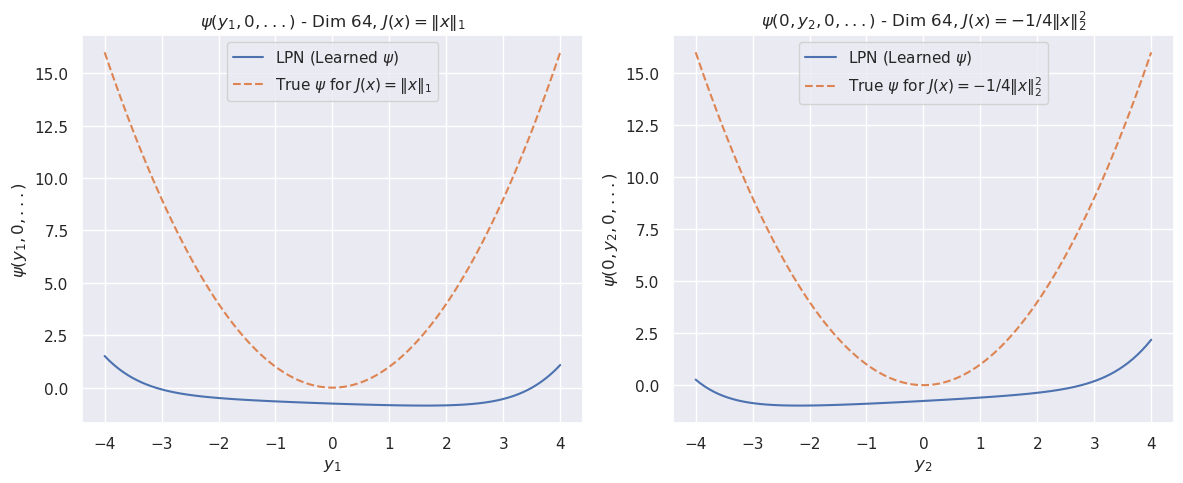

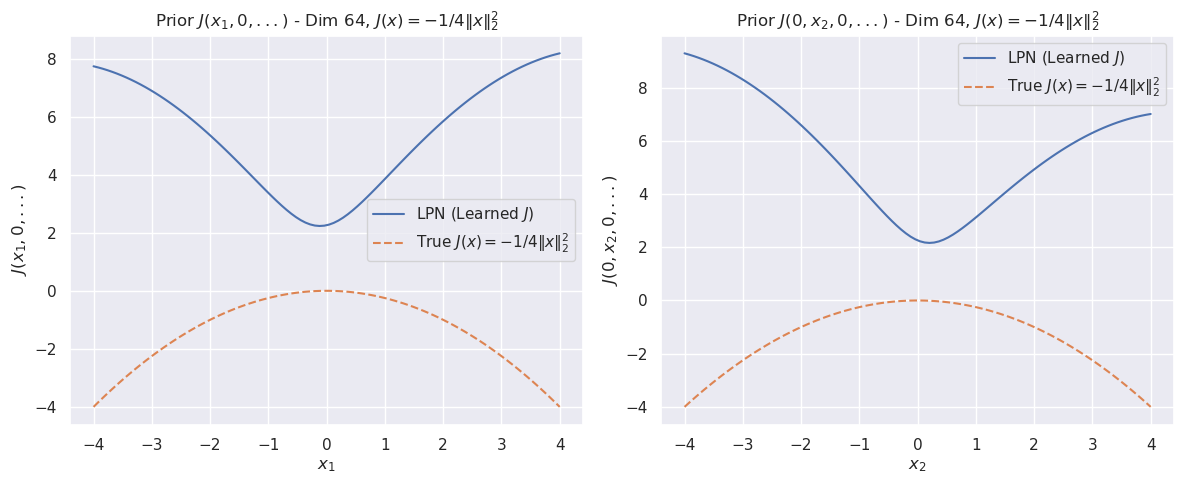

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.7370,  2.7081, -6.8593,  ..., -0.1345,  3.4257, -1.1737],
        [-3.7073,  0.5973,  2.2102,  ..., -0.0377, -0.3177,  4.0758],
        [-6.4841, -3.3082,  1.6375,  ...,  5.4461, -2.1451, -6.4170],
        ...,
        [-1.1682, -0.1209,  5.4125,  ...,  1.3146, -5.3247,  2.9330],
        [-2.7762,  4.0039,  5.9588,  ..., -6.1079, -2.0894, -0.3612],
        [ 3.6543, -0.1027, -6.0544,  ...,  2.7724, -4.7982, -6.1279]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"]/5 # * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 71219.453125
iteration 0 loss 36370.078125


iteration 500 loss 139.23916625976562


iteration 1000 loss 85.82659912109375


iteration 1500 loss 60.4614372253418


iteration 2000 loss 50.36390686035156


iteration 2500 loss 45.98616027832031


iteration 3000 loss 43.0487060546875


iteration 3500 loss 40.269317626953125


iteration 4000 loss 37.42892837524414


iteration 4500 loss 34.559661865234375


iteration 5000 loss 31.749187469482422


iteration 5500 loss 29.050443649291992


iteration 6000 loss 26.4683895111084


iteration 6500 loss 23.993621826171875


iteration 7000 loss 21.591588973999023


iteration 7500 loss 19.317766189575195


iteration 8000 loss 17.201377868652344


iteration 8500 loss 15.225432395935059


iteration 9000 loss 13.450900077819824


iteration 9500 loss 11.875876426696777


iteration 10000 loss 10.478358268737793


iteration 10500 loss 9.229765892028809


iteration 11000 loss 8.214949607849121


iteration 11500 loss 7.376906871795654


iteration 12000 loss 6.787962913513184


iteration 12500 loss 6.162045955657959


iteration 13000 loss 5.729298114776611


iteration 13500 loss 5.278275489807129


iteration 14000 loss 4.854003429412842


iteration 14500 loss 4.573965549468994


iteration 15000 loss 4.2449727058410645


iteration 15500 loss 3.8908870220184326


iteration 16000 loss 3.6819944381713867


iteration 16500 loss 3.4311187267303467


iteration 17000 loss 3.136032819747925


iteration 17500 loss 2.9819257259368896


iteration 18000 loss 2.812962770462036


iteration 18500 loss 2.609529733657837


iteration 19000 loss 2.3942675590515137


iteration 19500 loss 2.2961678504943848


iteration 20000 loss 2.176664113998413


iteration 20500 loss 2.0316367149353027


iteration 21000 loss 1.8600739240646362


iteration 21500 loss 1.7687010765075684


iteration 22000 loss 1.6841025352478027


iteration 22500 loss 1.5814224481582642


iteration 23000 loss 1.45930814743042


iteration 23500 loss 1.374105453491211


iteration 24000 loss 1.3203880786895752


iteration 24500 loss 1.2547966241836548


iteration 25000 loss 1.1759806871414185


iteration 25500 loss 1.0839072465896606


iteration 26000 loss 1.048657774925232


iteration 26500 loss 1.0090177059173584


iteration 27000 loss 0.9610550403594971


iteration 27500 loss 0.9039384722709656


iteration 28000 loss 0.8516589403152466


iteration 28500 loss 0.8282673358917236


iteration 29000 loss 0.8006046414375305


iteration 29500 loss 0.7669222354888916


iteration 30000 loss 0.7265811562538147


iteration 30500 loss 0.6891513466835022


iteration 31000 loss 0.6735479235649109


iteration 31500 loss 0.6553971171379089


iteration 32000 loss 0.6331424713134766


iteration 32500 loss 0.6061680316925049


iteration 33000 loss 0.5739859342575073


iteration 33500 loss 0.5595244765281677


iteration 34000 loss 0.5451022386550903


iteration 34500 loss 0.5274348258972168


iteration 35000 loss 0.505984365940094


iteration 35500 loss 0.4862830936908722


iteration 36000 loss 0.4745014011859894


iteration 36500 loss 0.4636164903640747


iteration 37000 loss 0.4502526819705963


iteration 37500 loss 0.4340396523475647


iteration 38000 loss 0.887474000453949


iteration 38500 loss 0.4093003571033478


iteration 39000 loss 0.4010753929615021


iteration 39500 loss 0.3909679055213928


iteration 40000 loss 0.37854188680648804


iteration 40500 loss 0.3634546399116516


iteration 41000 loss 0.3587418496608734


iteration 41500 loss 0.3528244197368622


iteration 42000 loss 0.34560441970825195


iteration 42500 loss 0.33666181564331055


iteration 43000 loss 0.3257901668548584


iteration 43500 loss 0.3173365294933319


iteration 44000 loss 0.31150415539741516


iteration 44500 loss 0.30602964758872986


iteration 45000 loss 0.29927533864974976


iteration 45500 loss 0.2909789979457855


iteration 46000 loss 0.28077107667922974


iteration 46500 loss 0.27649638056755066


iteration 47000 loss 0.27183958888053894


iteration 47500 loss 0.26621171832084656


iteration 48000 loss 0.25932133197784424


iteration 48500 loss 0.25098294019699097


iteration 49000 loss 0.2477392554283142


iteration 49500 loss 0.24456879496574402


iteration 50000 loss 0.24082604050636292


iteration 50500 loss 0.23617206513881683


iteration 51000 loss 0.23052038252353668


iteration 51500 loss 0.22343012690544128


iteration 52000 loss 0.22082459926605225


iteration 52500 loss 0.21746689081192017


iteration 53000 loss 0.2134450078010559


iteration 53500 loss 0.20847821235656738


iteration 54000 loss 0.20236322283744812


iteration 54500 loss 0.2010345607995987


iteration 55000 loss 0.19863398373126984


iteration 55500 loss 0.19597460329532623


iteration 56000 loss 0.19269289076328278


iteration 56500 loss 0.18862436711788177


iteration 57000 loss 0.1836646944284439


iteration 57500 loss 0.18169882893562317


iteration 58000 loss 0.1794523149728775


iteration 58500 loss 0.17682185769081116


iteration 59000 loss 0.17355726659297943


iteration 59500 loss 0.16962751746177673


iteration 60000 loss 0.16748400032520294


iteration 60500 loss 0.1649218648672104


iteration 61000 loss 0.16273781657218933


iteration 61500 loss 0.16008910536766052


iteration 62000 loss 0.15684591233730316


iteration 62500 loss 0.15616866946220398


iteration 63000 loss 0.15282279253005981


iteration 63500 loss 0.151213139295578


iteration 64000 loss 0.14940091967582703


iteration 64500 loss 0.14716582000255585


iteration 65000 loss 0.14443568885326385


iteration 65500 loss 13.243135452270508


iteration 66000 loss 0.140639528632164


iteration 66500 loss 0.13918372988700867


iteration 67000 loss 0.13766974210739136


iteration 67500 loss 0.1358187198638916


iteration 68000 loss 0.1335228681564331


iteration 68500 loss 0.13068124651908875


iteration 69000 loss 0.1302749663591385


iteration 69500 loss 0.12889087200164795


iteration 70000 loss 0.12752948701381683


iteration 70500 loss 0.1258784383535385


iteration 71000 loss 0.12406101822853088


iteration 71500 loss 0.12169655412435532


iteration 72000 loss 0.12062841653823853


iteration 72500 loss 0.11922558397054672


iteration 73000 loss 0.11769276857376099


iteration 73500 loss 0.11580687016248703


iteration 74000 loss 0.11403224617242813


iteration 74500 loss 0.11340487748384476


iteration 75000 loss 0.11221564561128616


iteration 75500 loss 0.11111041903495789


iteration 76000 loss 0.1097862496972084


iteration 76500 loss 0.10823135823011398


iteration 77000 loss 0.10610497742891312


iteration 77500 loss 0.10606668144464493


iteration 78000 loss 0.10476715862751007


iteration 78500 loss 0.10379278659820557


iteration 79000 loss 0.10267570614814758


iteration 79500 loss 0.10129907727241516


iteration 80000 loss 0.09959004819393158


iteration 80500 loss 0.09952591359615326


iteration 81000 loss 0.09817385673522949


iteration 81500 loss 0.09729425609111786


iteration 82000 loss 0.09630396217107773


iteration 82500 loss 0.09511955082416534


iteration 83000 loss 0.09370081126689911


iteration 83500 loss 0.09375913441181183


iteration 84000 loss 0.09227297455072403


iteration 84500 loss 0.09144943952560425


iteration 85000 loss 0.09056669473648071


iteration 85500 loss 0.08949870616197586


iteration 86000 loss 0.08847162872552872


iteration 86500 loss 0.08833447098731995


iteration 87000 loss 0.08684168756008148


iteration 87500 loss 0.08609136939048767


iteration 88000 loss 0.08528753370046616


iteration 88500 loss 0.08434406667947769


iteration 89000 loss 0.08308131992816925


iteration 89500 loss 0.08362648636102676


iteration 90000 loss 0.08192986249923706


iteration 90500 loss 0.08120283484458923


iteration 91000 loss 0.08049221336841583


iteration 91500 loss 0.07964179664850235


iteration 92000 loss 0.07861045002937317


iteration 92500 loss 0.10184644162654877


iteration 93000 loss 0.07753916829824448


iteration 93500 loss 0.07679799944162369


iteration 94000 loss 0.07615098357200623


iteration 94500 loss 0.07541515678167343


iteration 95000 loss 0.07446756213903427


iteration 95500 loss 0.1164398267865181


iteration 96000 loss 0.07331879436969757


iteration 96500 loss 0.07256629317998886


iteration 97000 loss 0.07184197008609772


iteration 97500 loss 0.07097424566745758


iteration 98000 loss 1.2171545028686523


iteration 98500 loss 0.07022030651569366


iteration 99000 loss 0.06947997957468033


iteration 99500 loss 0.0689089372754097


Learning rate decreased to 2e-05 at iteration 100000
iteration 100000 loss 0.0682760626077652


iteration 100500 loss 0.06810565292835236


iteration 101000 loss 0.06790219247341156


iteration 101500 loss 0.06764349341392517


iteration 102000 loss 0.06731443852186203


iteration 102500 loss 0.06689673662185669


iteration 103000 loss 0.06636715680360794


iteration 103500 loss 0.06569826602935791


iteration 104000 loss 0.06487011909484863


iteration 104500 loss 0.06408156454563141


iteration 105000 loss 0.06376567482948303


iteration 105500 loss 0.06341835111379623


iteration 106000 loss 0.06297752261161804


iteration 106500 loss 0.06241987273097038


iteration 107000 loss 0.061714109033346176


iteration 107500 loss 0.06082766130566597


iteration 108000 loss 0.0604894757270813


iteration 108500 loss 0.06014552339911461


iteration 109000 loss 0.059713397175073624


iteration 109500 loss 0.05916609987616539


iteration 110000 loss 0.058476902544498444


iteration 110500 loss 0.05783689394593239


iteration 111000 loss 0.05743454396724701


iteration 111500 loss 0.057059820741415024


iteration 112000 loss 0.05658559501171112


iteration 112500 loss 0.05598779022693634


iteration 113000 loss 0.055254336446523666


iteration 113500 loss 0.05490034073591232


iteration 114000 loss 0.05459656938910484


iteration 114500 loss 0.054215703159570694


iteration 115000 loss 0.05373334884643555


iteration 115500 loss 0.05313602089881897


iteration 116000 loss 0.05260279402136803


iteration 116500 loss 0.052317820489406586


iteration 117000 loss 0.052075255662202835


iteration 117500 loss 0.051768992096185684


iteration 118000 loss 0.05138002708554268


iteration 118500 loss 0.05089673772454262


iteration 119000 loss 0.050268981605768204


iteration 119500 loss 0.04992534592747688


iteration 120000 loss 0.04969163239002228


iteration 120500 loss 0.04940760135650635


iteration 121000 loss 0.04904772341251373


iteration 121500 loss 0.04859514534473419


iteration 122000 loss 0.0480186901986599


iteration 122500 loss 0.04766817390918732


iteration 123000 loss 0.04745393618941307


iteration 123500 loss 0.04720235615968704


iteration 124000 loss 0.04688416048884392


iteration 124500 loss 0.046481236815452576


iteration 125000 loss 0.04597112908959389


iteration 125500 loss 0.045591115951538086


iteration 126000 loss 0.04540582373738289


iteration 126500 loss 0.0451911985874176


iteration 127000 loss 0.044918738305568695


iteration 127500 loss 0.04457319900393486


iteration 128000 loss 0.044138792902231216


iteration 128500 loss 0.0453459769487381


iteration 129000 loss 0.04347259923815727


iteration 129500 loss 0.04327167943120003


iteration 130000 loss 0.043020639568567276


iteration 130500 loss 0.04270212724804878


iteration 131000 loss 0.042300399392843246


iteration 131500 loss 0.0417933389544487


iteration 132000 loss 0.04166455566883087


iteration 132500 loss 0.04150231182575226


iteration 133000 loss 0.04130156710743904


iteration 133500 loss 0.04104657471179962


iteration 134000 loss 0.04072285816073418


iteration 134500 loss 0.040315404534339905


iteration 135000 loss 0.03998624160885811


iteration 135500 loss 0.03978359326720238


iteration 136000 loss 0.039564523845911026


iteration 136500 loss 0.03928738087415695


iteration 137000 loss 0.038937393575906754


iteration 137500 loss 0.038499969989061356


iteration 138000 loss 0.038335759192705154


iteration 138500 loss 0.038148608058691025


iteration 139000 loss 0.03791456297039986


iteration 139500 loss 0.03761782869696617


iteration 140000 loss 0.037242889404296875


iteration 140500 loss 0.0369735024869442


iteration 141000 loss 0.03679802641272545


iteration 141500 loss 0.036598771810531616


iteration 142000 loss 0.03634684532880783


iteration 142500 loss 0.03603973984718323


iteration 143000 loss 0.044708989560604095


iteration 143500 loss 0.035530541092157364


iteration 144000 loss 0.03538839519023895


iteration 144500 loss 0.03520938754081726


iteration 145000 loss 0.03498271480202675


iteration 145500 loss 0.03469390049576759


iteration 146000 loss 0.034330759197473526


iteration 146500 loss 0.034182798117399216


iteration 147000 loss 0.03402451053261757


iteration 147500 loss 0.033827800303697586


iteration 148000 loss 0.03357822820544243


iteration 148500 loss 0.03326285630464554


iteration 149000 loss 0.03305802494287491


iteration 149500 loss 0.03293026611208916


iteration 150000 loss 0.03280622512102127


iteration 150500 loss 0.032649893313646317


iteration 151000 loss 0.0324515625834465


iteration 151500 loss 0.032200127840042114


iteration 152000 loss 0.031888432800769806


iteration 152500 loss 0.03175819665193558


iteration 153000 loss 0.03164967522025108


iteration 153500 loss 0.03152167797088623


iteration 154000 loss 0.031359728425741196


iteration 154500 loss 0.031154125928878784


iteration 155000 loss 0.03089408576488495


iteration 155500 loss 0.03143281862139702


iteration 156000 loss 0.030530279502272606


iteration 156500 loss 0.03042670153081417


iteration 157000 loss 0.030298754572868347


iteration 157500 loss 0.030136320739984512


iteration 158000 loss 0.029933776706457138


iteration 158500 loss 0.029669124633073807


iteration 159000 loss 0.029509350657463074


iteration 159500 loss 0.029402269050478935


iteration 160000 loss 0.029292883351445198


iteration 160500 loss 0.029155192896723747


iteration 161000 loss 0.02898591198027134


iteration 161500 loss 0.02875782735645771


iteration 162000 loss 0.028477303683757782


iteration 162500 loss 0.02840391732752323


iteration 163000 loss 0.02831130288541317


iteration 163500 loss 0.028200166299939156


iteration 164000 loss 0.028058987110853195


iteration 164500 loss 0.027879759669303894


iteration 165000 loss 0.02765204943716526


iteration 165500 loss 0.027511993423104286


iteration 166000 loss 0.027356132864952087


iteration 166500 loss 0.02724531851708889


iteration 167000 loss 0.027107255533337593


iteration 167500 loss 0.02693239599466324


iteration 168000 loss 0.02671138197183609


iteration 168500 loss 0.02655559964478016


iteration 169000 loss 0.02642853558063507


iteration 169500 loss 0.02630913071334362


iteration 170000 loss 0.02615894190967083


iteration 170500 loss 0.025969719514250755


iteration 171000 loss 0.025728868320584297


iteration 171500 loss 0.025667009875178337


iteration 172000 loss 0.02558145858347416


iteration 172500 loss 0.025484252721071243


iteration 173000 loss 0.0253615602850914


iteration 173500 loss 0.02520964853465557


iteration 174000 loss 0.02501203864812851


iteration 174500 loss 0.02486465312540531


iteration 175000 loss 0.024769457057118416


iteration 175500 loss 0.02467646636068821


iteration 176000 loss 0.024558989331126213


iteration 176500 loss 0.024410754442214966


iteration 177000 loss 0.02422061748802662


iteration 177500 loss 0.02409173920750618


iteration 178000 loss 0.024000605568289757


iteration 178500 loss 0.02391698770225048


iteration 179000 loss 0.023811781778931618


iteration 179500 loss 0.023678122088313103


iteration 180000 loss 0.023508254438638687


iteration 180500 loss 0.025950860232114792


iteration 181000 loss 0.02324589528143406


iteration 181500 loss 0.023159107193350792


iteration 182000 loss 0.023051923140883446


iteration 182500 loss 0.022916369140148163


iteration 183000 loss 0.022743577137589455


iteration 183500 loss 0.0226295068860054


iteration 184000 loss 0.02251717820763588


iteration 184500 loss 0.02242160588502884


iteration 185000 loss 0.022301852703094482


iteration 185500 loss 0.02215394750237465


iteration 186000 loss 0.12673918902873993


iteration 186500 loss 0.021921562030911446


iteration 187000 loss 0.021854152902960777


iteration 187500 loss 0.021775372326374054


iteration 188000 loss 0.021675871685147285


iteration 188500 loss 0.021551666781306267


iteration 189000 loss 0.021391067653894424


iteration 189500 loss 0.02130342274904251


iteration 190000 loss 0.021207939833402634


iteration 190500 loss 0.0211423859000206


iteration 191000 loss 0.021061785519123077


iteration 191500 loss 0.020959530025720596


iteration 192000 loss 0.020829524844884872


iteration 192500 loss 0.020664604380726814


iteration 193000 loss 0.02060440368950367


iteration 193500 loss 0.020538967102766037


iteration 194000 loss 0.020470600575208664


iteration 194500 loss 0.020385121926665306


iteration 195000 loss 0.020279312506318092


iteration 195500 loss 0.020141923800110817


iteration 196000 loss 0.027787910774350166


iteration 196500 loss 0.01994287595152855


iteration 197000 loss 0.0198851078748703


iteration 197500 loss 0.019817063584923744


iteration 198000 loss 0.01973121240735054


iteration 198500 loss 0.01962210424244404


iteration 199000 loss 0.019484566524624825


iteration 199500 loss 0.01942366361618042


Learning rate decreased to 4.000000000000001e-06 at iteration 200000
iteration 200000 loss 0.019308995455503464


iteration 200500 loss 0.01929454691708088


iteration 201000 loss 0.019276266917586327


iteration 201500 loss 0.019252834841609


iteration 202000 loss 0.01922326721251011


iteration 202500 loss 0.019186293706297874


iteration 203000 loss 0.019139373674988747


iteration 203500 loss 0.019079314544796944


iteration 204000 loss 0.019002823159098625


iteration 204500 loss 0.018905414268374443


iteration 205000 loss 0.018781594932079315


iteration 205500 loss 0.019193289801478386


iteration 206000 loss 0.018594227731227875


iteration 206500 loss 0.018544459715485573


iteration 207000 loss 0.01848069205880165


iteration 207500 loss 0.018399499356746674


iteration 208000 loss 0.018296018242836


iteration 208500 loss 0.01816471852362156


iteration 209000 loss 0.01806417852640152


iteration 209500 loss 0.018011050298810005


iteration 210000 loss 0.017943421378731728


iteration 210500 loss 0.0178570244461298


iteration 211000 loss 0.017747284844517708


iteration 211500 loss 0.01760813035070896


iteration 212000 loss 0.017551125958561897


iteration 212500 loss 0.017501557245850563


iteration 213000 loss 0.017437996342778206


iteration 213500 loss 0.01735694706439972


iteration 214000 loss 0.01725389063358307


iteration 214500 loss 0.017123430967330933


iteration 215000 loss 0.017064550891518593


iteration 215500 loss 0.017023393884301186


iteration 216000 loss 0.016970526427030563


iteration 216500 loss 0.016903124749660492


iteration 217000 loss 0.016817254945635796


iteration 217500 loss 0.016708148643374443


iteration 218000 loss 0.016595186665654182


iteration 218500 loss 0.016550660133361816


iteration 219000 loss 0.016495531424880028


iteration 219500 loss 0.016425414010882378


iteration 220000 loss 0.016336139291524887


iteration 220500 loss 0.016222858801484108


iteration 221000 loss 0.016143018379807472


iteration 221500 loss 0.016105646267533302


iteration 222000 loss 0.01605791039764881


iteration 222500 loss 0.01599680632352829


iteration 223000 loss 0.015918970108032227


iteration 223500 loss 0.01581989787518978


iteration 224000 loss 0.01571519486606121


iteration 224500 loss 0.015663184225559235


iteration 225000 loss 0.015609005466103554


iteration 225500 loss 0.01554011832922697


iteration 226000 loss 0.01545235887169838


iteration 226500 loss 0.015340758487582207


iteration 227000 loss 0.015285331755876541


iteration 227500 loss 0.015240846201777458


iteration 228000 loss 0.015183855779469013


iteration 228500 loss 0.015111211687326431


iteration 229000 loss 0.015019036829471588


iteration 229500 loss 0.014923026785254478


iteration 230000 loss 0.014885290525853634


iteration 230500 loss 0.014848812483251095


iteration 231000 loss 0.014802210964262486


iteration 231500 loss 0.014742557890713215


iteration 232000 loss 0.014666574075818062


iteration 232500 loss 0.014570203609764576


iteration 233000 loss 0.014497678726911545


iteration 233500 loss 0.014463908039033413


iteration 234000 loss 0.014421111904084682


iteration 234500 loss 0.014366308227181435


iteration 235000 loss 0.014296606183052063


iteration 235500 loss 0.014207972213625908


iteration 236000 loss 0.014123461209237576


iteration 236500 loss 0.01409485749900341


iteration 237000 loss 0.014059693552553654


iteration 237500 loss 0.01401467528194189


iteration 238000 loss 0.013957100920379162


iteration 238500 loss 0.013883761130273342


iteration 239000 loss 0.013790633529424667


iteration 239500 loss 0.01373595092445612


iteration 240000 loss 0.013707444071769714


iteration 240500 loss 0.013671189546585083


iteration 241000 loss 0.013624672777950764


iteration 241500 loss 0.013565517961978912


iteration 242000 loss 0.013490244746208191


iteration 242500 loss 0.013394860550761223


iteration 243000 loss 0.013363946229219437


iteration 243500 loss 0.013334594666957855


iteration 244000 loss 0.013297229073941708


iteration 244500 loss 0.013249161653220654


iteration 245000 loss 0.013188323937356472


iteration 245500 loss 0.01311048585921526


iteration 246000 loss 0.013029078021645546


iteration 246500 loss 0.013000192120671272


iteration 247000 loss 0.012965243309736252


iteration 247500 loss 0.012920472770929337


iteration 248000 loss 0.012863393872976303


iteration 248500 loss 0.012791098095476627


iteration 249000 loss 0.013949038460850716


iteration 249500 loss 0.012680795043706894


iteration 250000 loss 0.012652561068534851


iteration 250500 loss 0.012616592459380627


iteration 251000 loss 0.012570361606776714


iteration 251500 loss 0.012511641718447208


iteration 252000 loss 0.012437120079994202


iteration 252500 loss 0.012369727715849876


iteration 253000 loss 0.012346095405519009


iteration 253500 loss 0.012317423708736897


iteration 254000 loss 0.012280808761715889


iteration 254500 loss 0.01223379373550415


iteration 255000 loss 0.012174251489341259


iteration 255500 loss 0.012098198756575584


iteration 256000 loss 0.012045681476593018


iteration 256500 loss 0.012022387236356735


iteration 257000 loss 0.01199319027364254


iteration 257500 loss 0.011955905705690384


iteration 258000 loss 0.011908073909580708


iteration 258500 loss 0.011847424320876598


iteration 259000 loss 0.011770160868763924


iteration 259500 loss 0.011728080920875072


iteration 260000 loss 0.011697102338075638


iteration 260500 loss 0.011657449416816235


iteration 261000 loss 0.011607007123529911


iteration 261500 loss 0.01154258195310831


iteration 262000 loss 0.011474639177322388


iteration 262500 loss 0.011444821022450924


iteration 263000 loss 0.011410761624574661


iteration 263500 loss 0.011367114260792732


iteration 264000 loss 0.011311651207506657


iteration 264500 loss 0.011241256259381771


iteration 265000 loss 0.011198966763913631


iteration 265500 loss 0.011174211278557777


iteration 266000 loss 0.011142946779727936


iteration 266500 loss 0.011102834716439247


iteration 267000 loss 0.011051845736801624


iteration 267500 loss 0.010986966080963612


iteration 268000 loss 0.010933445766568184


iteration 268500 loss 0.010906611569225788


iteration 269000 loss 0.010872824117541313


iteration 269500 loss 0.010829553008079529


iteration 270000 loss 0.010774520225822926


iteration 270500 loss 0.010704671032726765


iteration 271000 loss 0.01068094652146101


iteration 271500 loss 0.010659272782504559


iteration 272000 loss 0.010631999932229519


iteration 272500 loss 0.010596968233585358


iteration 273000 loss 0.010552327148616314


iteration 273500 loss 0.010495408438146114


iteration 274000 loss 0.01043664664030075


iteration 274500 loss 0.010414748452603817


iteration 275000 loss 0.010388670489192009


iteration 275500 loss 0.01035534217953682


iteration 276000 loss 0.010312751866877079


iteration 276500 loss 0.010258575901389122


iteration 277000 loss 0.010591519996523857


iteration 277500 loss 0.010177992284297943


iteration 278000 loss 0.010156835429370403


iteration 278500 loss 0.010129978880286217


iteration 279000 loss 0.010095678269863129


iteration 279500 loss 0.010051826015114784


iteration 280000 loss 0.00999615341424942


iteration 280500 loss 0.009947296231985092


iteration 281000 loss 0.00992938969284296


iteration 281500 loss 0.009908044710755348


iteration 282000 loss 0.009881043806672096


iteration 282500 loss 0.009846367873251438


iteration 283000 loss 0.009802302345633507


iteration 283500 loss 0.009746395982801914


iteration 284000 loss 0.009705813601613045


iteration 284500 loss 0.009685235098004341


iteration 285000 loss 0.009659582749009132


iteration 285500 loss 0.009626849554479122


iteration 286000 loss 0.009585102088749409


iteration 286500 loss 0.009531785733997822


iteration 287000 loss 0.009490326046943665


iteration 287500 loss 0.0094724977388978


iteration 288000 loss 0.009450841695070267


iteration 288500 loss 0.009423227980732918


iteration 289000 loss 0.009387965314090252


iteration 289500 loss 0.009343256242573261


iteration 290000 loss 0.009285991080105305


iteration 290500 loss 0.009263461455702782


iteration 291000 loss 0.009242141619324684


iteration 291500 loss 0.009214994497597218


iteration 292000 loss 0.009180285967886448


iteration 292500 loss 0.009136351756751537


iteration 293000 loss 0.009080959483981133


iteration 293500 loss 0.009063253179192543


iteration 294000 loss 0.009043951518833637


iteration 294500 loss 0.009019527584314346


iteration 295000 loss 0.008988387882709503


iteration 295500 loss 0.008948508650064468


iteration 296000 loss 0.008897879160940647


iteration 296500 loss 0.00886737834662199


iteration 297000 loss 0.00885144341737032


iteration 297500 loss 0.008831615559756756


iteration 298000 loss 0.008806527592241764


iteration 298500 loss 0.008774378336966038


iteration 299000 loss 0.008733503520488739


iteration 299500 loss 0.008681346662342548


Learning rate decreased to 8.000000000000002e-07 at iteration 300000
iteration 300000 loss 0.008664984256029129


iteration 300500 loss 0.008662175387144089


iteration 301000 loss 0.008658510632812977


iteration 301500 loss 0.008653536438941956


iteration 302000 loss 0.008647036738693714


iteration 302500 loss 0.008638598024845123


iteration 303000 loss 0.008627327159047127


iteration 303500 loss 0.008612844161689281


iteration 304000 loss 0.008594497106969357


iteration 304500 loss 0.008571267127990723


iteration 305000 loss 0.008541643619537354


iteration 305500 loss 0.008503837510943413


iteration 306000 loss 0.008456100709736347


iteration 306500 loss 0.008424987085163593


iteration 307000 loss 0.008403854444622993


iteration 307500 loss 0.008376899175345898


iteration 308000 loss 0.008342391811311245


iteration 308500 loss 0.008298794738948345


iteration 309000 loss 0.008258461952209473


iteration 309500 loss 0.008239763788878918


iteration 310000 loss 0.008215952664613724


iteration 310500 loss 0.008185560815036297


iteration 311000 loss 0.008146900683641434


iteration 311500 loss 0.008286251686513424


iteration 312000 loss 0.008078678511083126


iteration 312500 loss 0.008054191246628761


iteration 313000 loss 0.008022908121347427


iteration 313500 loss 0.00798319187015295


iteration 314000 loss 0.007940435782074928


iteration 314500 loss 0.007922915741801262


iteration 315000 loss 0.007900787517428398


iteration 315500 loss 0.007872502319514751


iteration 316000 loss 0.00783645547926426


iteration 316500 loss 0.007790842093527317


iteration 317000 loss 0.007766467984765768


iteration 317500 loss 0.007737914100289345


iteration 318000 loss 0.007701579015702009


iteration 318500 loss 0.007658315822482109


iteration 319000 loss 0.007637093774974346


iteration 319500 loss 0.007610847242176533


iteration 320000 loss 0.0075773573480546474


iteration 320500 loss 0.007535071577876806


iteration 321000 loss 0.007511710282415152


iteration 321500 loss 0.007491192314773798


iteration 322000 loss 0.007464988622814417


iteration 322500 loss 0.007431579288095236


iteration 323000 loss 0.007389294449239969


iteration 323500 loss 0.007371077314019203


iteration 324000 loss 0.007353111170232296


iteration 324500 loss 0.007330236490815878


iteration 325000 loss 0.007301017642021179


iteration 325500 loss 0.007263876032084227


iteration 326000 loss 0.007233479060232639


iteration 326500 loss 0.007217437494546175


iteration 327000 loss 0.00719713419675827


iteration 327500 loss 0.007171277422457933


iteration 328000 loss 0.0071382164023816586


iteration 328500 loss 0.007099505513906479


iteration 329000 loss 0.007080848328769207


iteration 329500 loss 0.0070589338429272175


iteration 330000 loss 0.007030820939689875


iteration 330500 loss 0.006995263509452343


iteration 331000 loss 0.006965986452996731


iteration 331500 loss 0.006948080379515886


iteration 332000 loss 0.006925239227712154


iteration 332500 loss 0.006896124221384525


iteration 333000 loss 0.006859258282929659


iteration 333500 loss 0.00683475099503994


iteration 334000 loss 0.0068131559528410435


iteration 334500 loss 0.006785552948713303


iteration 335000 loss 0.0067504760809242725


iteration 335500 loss 0.006726670078933239


iteration 336000 loss 0.006712126545608044


iteration 336500 loss 0.00669372221454978


iteration 337000 loss 0.006670303177088499


iteration 337500 loss 0.006640380714088678


iteration 338000 loss 0.006605460774153471


iteration 338500 loss 0.0065906173549592495


iteration 339000 loss 0.006573118269443512


iteration 339500 loss 0.0065508619882166386


iteration 340000 loss 0.006522385403513908


iteration 340500 loss 0.00648648152127862


iteration 341000 loss 0.006472779903560877


iteration 341500 loss 0.0064573041163384914


iteration 342000 loss 0.006437753327190876


iteration 342500 loss 0.006412742659449577


iteration 343000 loss 0.006380977109074593


iteration 343500 loss 0.006357614882290363


iteration 344000 loss 0.006344289984554052


iteration 344500 loss 0.00632742652669549


iteration 345000 loss 0.006305941380560398


iteration 345500 loss 0.006278521381318569


iteration 346000 loss 0.0062445723451673985


iteration 346500 loss 0.006230090279132128


iteration 347000 loss 0.006213135551661253


iteration 347500 loss 0.006191582418978214


iteration 348000 loss 0.006164044141769409


iteration 348500 loss 0.006132530514150858


iteration 349000 loss 0.006118948105722666


iteration 349500 loss 0.006101908162236214


iteration 350000 loss 0.006080139894038439


iteration 350500 loss 0.006052433047443628


iteration 351000 loss 0.00602424843236804


iteration 351500 loss 0.006012899801135063


iteration 352000 loss 0.005998465232551098


iteration 352500 loss 0.005980194080621004


iteration 353000 loss 0.005956943146884441


iteration 353500 loss 0.005927389021962881


iteration 354000 loss 0.005908121354877949


iteration 354500 loss 0.005895830225199461


iteration 355000 loss 0.005880353972315788


iteration 355500 loss 0.005860601551830769


iteration 356000 loss 0.0058354828506708145


iteration 356500 loss 0.005808374844491482


iteration 357000 loss 0.00579473003745079


iteration 357500 loss 0.005781358107924461


iteration 358000 loss 0.005764495115727186


iteration 358500 loss 0.005743024870753288


iteration 359000 loss 0.005715623963624239


iteration 359500 loss 0.005693850573152304


iteration 360000 loss 0.005680988542735577


iteration 360500 loss 0.00566471554338932


iteration 361000 loss 0.005643985699862242


iteration 361500 loss 0.005617573391646147


iteration 362000 loss 0.005596248432993889


iteration 362500 loss 0.005585521459579468


iteration 363000 loss 0.005571979563683271


iteration 363500 loss 0.005554776638746262


iteration 364000 loss 0.0055328793823719025


iteration 364500 loss 0.005505028180778027


iteration 365000 loss 0.005490961950272322


iteration 365500 loss 0.005479639396071434


iteration 366000 loss 0.00546529283747077


iteration 366500 loss 0.0054471455514431


iteration 367000 loss 0.005423921626061201


iteration 367500 loss 0.0053973752073943615


iteration 368000 loss 0.00538786593824625


iteration 368500 loss 0.005375696811825037


iteration 369000 loss 0.0053603858686983585


iteration 369500 loss 0.005340852774679661


iteration 370000 loss 0.005315973423421383


iteration 370500 loss 0.005296724382787943


iteration 371000 loss 0.005286098923534155


iteration 371500 loss 0.005272565875202417


iteration 372000 loss 0.005255487747490406


iteration 372500 loss 0.00523364869877696


iteration 373000 loss 0.00520773371681571


iteration 373500 loss 0.005195237696170807


iteration 374000 loss 0.00517998356372118


iteration 374500 loss 0.005160513333976269


iteration 375000 loss 0.005135708022862673


iteration 375500 loss 0.005119484383612871


iteration 376000 loss 0.005106439348310232


iteration 376500 loss 0.005089996848255396


iteration 377000 loss 0.005068973638117313


iteration 377500 loss 0.005045959260314703


iteration 378000 loss 0.0050355480052530766


iteration 378500 loss 0.0050249588675796986


iteration 379000 loss 0.005011625587940216


iteration 379500 loss 0.004994748625904322


iteration 380000 loss 0.004973208531737328


iteration 380500 loss 0.0049519301392138


iteration 381000 loss 0.004942271858453751


iteration 381500 loss 0.004930020775645971


iteration 382000 loss 0.004914540797472


iteration 382500 loss 0.004894803278148174


iteration 383000 loss 0.004884465131908655


iteration 383500 loss 0.0048587629571557045


iteration 384000 loss 0.0048450143076479435


iteration 384500 loss 0.004827549681067467


iteration 385000 loss 0.00480528874322772


iteration 385500 loss 0.004788408987224102


iteration 386000 loss 0.004775871057063341


iteration 386500 loss 0.0047599924728274345


iteration 387000 loss 0.004739743657410145


iteration 387500 loss 0.004718070384114981


iteration 388000 loss 0.004709811881184578


iteration 388500 loss 0.004699165467172861


iteration 389000 loss 0.004685759544372559


iteration 389500 loss 0.004668738227337599


iteration 390000 loss 0.004647048655897379


iteration 390500 loss 0.004633033648133278


iteration 391000 loss 0.004623791668564081


iteration 391500 loss 0.0046121105551719666


iteration 392000 loss 0.0045972950756549835


iteration 392500 loss 0.004578437656164169


iteration 393000 loss 0.004556854255497456


iteration 393500 loss 0.004548961296677589


iteration 394000 loss 0.004538767505437136


iteration 394500 loss 0.0045259566977620125


iteration 395000 loss 0.004509700462222099


iteration 395500 loss 0.004488994367420673


iteration 396000 loss 0.004475511610507965


iteration 396500 loss 0.004468017257750034


iteration 397000 loss 0.004458343610167503


iteration 397500 loss 0.0044461400248110294


iteration 398000 loss 0.004430693108588457


iteration 398500 loss 0.004410955123603344


iteration 399000 loss 0.004394697491079569


iteration 399500 loss 0.004385842941701412


Learning rate decreased to 1.6000000000000003e-07 at iteration 400000
iteration 400000 loss 0.004374566487967968


iteration 400500 loss 0.0043719857931137085


iteration 401000 loss 0.00436851242557168


iteration 401500 loss 0.004364013206213713


iteration 402000 loss 0.004358066711574793


iteration 402500 loss 0.004350325558334589


iteration 403000 loss 0.004340493120253086


iteration 403500 loss 0.004328170791268349


iteration 404000 loss 0.004312991630285978


iteration 404500 loss 0.004294439218938351


iteration 405000 loss 0.004273820202797651


iteration 405500 loss 0.004253324121236801


iteration 406000 loss 0.00423279358074069


iteration 406500 loss 0.004212346859276295


iteration 407000 loss 0.0041922153905034065


iteration 407500 loss 0.004172292537987232


iteration 408000 loss 0.004152224399149418


iteration 408500 loss 0.004132280126214027


iteration 409000 loss 0.004112493246793747


iteration 409500 loss 0.0040926244109869


iteration 410000 loss 0.0040727900341153145


iteration 410500 loss 0.0040536425076425076


iteration 411000 loss 0.0040345205925405025


iteration 411500 loss 0.004016079939901829


iteration 412000 loss 0.003996940329670906


iteration 412500 loss 0.003978240769356489


iteration 413000 loss 0.003959120251238346


iteration 413500 loss 0.003940353635698557


iteration 414000 loss 0.0039222873747348785


iteration 414500 loss 0.003903671633452177


iteration 415000 loss 0.0038852309808135033


iteration 415500 loss 0.0038668708875775337


iteration 416000 loss 0.0038486781995743513


iteration 416500 loss 0.0038304065819829702


iteration 417000 loss 0.0038121219258755445


iteration 417500 loss 0.0037942007184028625


iteration 418000 loss 0.003776224097236991


iteration 418500 loss 0.0037593466695398092


iteration 419000 loss 0.0037418166175484657


iteration 419500 loss 0.003724814858287573


iteration 420000 loss 0.003707347670570016


iteration 420500 loss 0.0036897959653288126


iteration 421000 loss 0.003672938095405698


iteration 421500 loss 0.003656150074675679


iteration 422000 loss 0.0036390700843185186


iteration 422500 loss 0.0036223242059350014


iteration 423000 loss 0.003605589270591736


iteration 423500 loss 0.003588875522837043


iteration 424000 loss 0.003572191810235381


iteration 424500 loss 0.0035558112431317568


iteration 425000 loss 0.0035393566358834505


iteration 425500 loss 0.0035228191409260035


iteration 426000 loss 0.003506446722894907


iteration 426500 loss 0.0034902060870081186


iteration 427000 loss 0.0034743391443043947


iteration 427500 loss 0.0034583164379000664


iteration 428000 loss 0.0034425361081957817


iteration 428500 loss 0.0034270717296749353


iteration 429000 loss 0.0034114026930183172


iteration 429500 loss 0.00339587964117527


iteration 430000 loss 0.003380101639777422


iteration 430500 loss 0.003364846808835864


iteration 431000 loss 0.003349579870700836


iteration 431500 loss 0.003334426786750555


iteration 432000 loss 0.0033197731245309114


iteration 432500 loss 0.003304969286546111


iteration 433000 loss 0.003290063003078103


iteration 433500 loss 0.003275199793279171


iteration 434000 loss 0.003260127268731594


iteration 434500 loss 0.0032463720999658108


iteration 435000 loss 0.0032319845631718636


iteration 435500 loss 0.0032171180937439203


iteration 436000 loss 0.0032036323100328445


iteration 436500 loss 0.0031891693361103535


iteration 437000 loss 0.003174769226461649


iteration 437500 loss 0.0031613344326615334


iteration 438000 loss 0.003146864240989089


iteration 438500 loss 0.0031332743819803


iteration 439000 loss 0.0031191848684102297


iteration 439500 loss 0.0031050548423081636


iteration 440000 loss 0.0030928885098546743


iteration 440500 loss 0.0030789729207754135


iteration 441000 loss 0.0030652720015496016


iteration 441500 loss 0.0030518725980073214


iteration 442000 loss 0.003039031056687236


iteration 442500 loss 0.003025419544428587


iteration 443000 loss 0.0030127204954624176


iteration 443500 loss 0.0029989713802933693


iteration 444000 loss 0.0029864551033824682


iteration 444500 loss 0.0029730768874287605


iteration 445000 loss 0.002959806239232421


iteration 445500 loss 0.0029470084700733423


iteration 446000 loss 0.0029348554089665413


iteration 446500 loss 0.002921962644904852


iteration 447000 loss 0.0029088864102959633


iteration 447500 loss 0.0028969496488571167


iteration 448000 loss 0.0028841278981417418


iteration 448500 loss 0.00287143443711102


iteration 449000 loss 0.0028591607697308064


iteration 449500 loss 0.0028470878023654222


iteration 450000 loss 0.002835110994055867


iteration 450500 loss 0.002823035465553403


iteration 451000 loss 0.002810622565448284


iteration 451500 loss 0.002798752160742879


iteration 452000 loss 0.002787211909890175


iteration 452500 loss 0.002774815773591399


iteration 453000 loss 0.002762831747531891


iteration 453500 loss 0.002751410473138094


iteration 454000 loss 0.0027392639312893152


iteration 454500 loss 0.002727626357227564


iteration 455000 loss 0.0027155661955475807


iteration 455500 loss 0.0027037826366722584


iteration 456000 loss 0.0026928673032671213


iteration 456500 loss 0.0026808567345142365


iteration 457000 loss 0.0026698485016822815


iteration 457500 loss 0.00265840208157897


iteration 458000 loss 0.0026470664888620377


iteration 458500 loss 0.0026365178637206554


iteration 459000 loss 0.002625061431899667


iteration 459500 loss 0.0026138052344322205


iteration 460000 loss 0.0026030056178569794


iteration 460500 loss 0.0025915796868503094


iteration 461000 loss 0.0025808780919760466


iteration 461500 loss 0.0025700656697154045


iteration 462000 loss 0.0025588516145944595


iteration 462500 loss 0.002549313008785248


iteration 463000 loss 0.002538252854719758


iteration 463500 loss 0.0025282897986471653


iteration 464000 loss 0.002518732100725174


iteration 464500 loss 0.002507605357095599


iteration 465000 loss 0.0024983135517686605


iteration 465500 loss 0.0024878059048205614


iteration 466000 loss 0.0024779867380857468


iteration 466500 loss 0.0024678530171513557


iteration 467000 loss 0.0024572741240262985


iteration 467500 loss 0.002446369966492057


iteration 468000 loss 0.002437768504023552


iteration 468500 loss 0.0024273681920021772


iteration 469000 loss 0.0024166363291442394


iteration 469500 loss 0.0024066700134426355


iteration 470000 loss 0.002396324882283807


iteration 470500 loss 0.002387358108535409


iteration 471000 loss 0.002377055585384369


iteration 471500 loss 0.0023666454944759607


iteration 472000 loss 0.0023574784863740206


iteration 472500 loss 0.002348104026168585


iteration 473000 loss 0.0023388892877846956


iteration 473500 loss 0.0023296878207474947


iteration 474000 loss 0.0023200497962534428


iteration 474500 loss 0.002310302574187517


iteration 475000 loss 0.0023008573334664106


iteration 475500 loss 0.002291489392518997


iteration 476000 loss 0.0022820732556283474


iteration 476500 loss 0.002272125566378236


iteration 477000 loss 0.002262757159769535


iteration 477500 loss 0.002253790618851781


iteration 478000 loss 0.00224393792450428


iteration 478500 loss 0.0022341585718095303


iteration 479000 loss 0.0022245943546295166


iteration 479500 loss 0.002215198939666152


iteration 480000 loss 0.0022054777946323156


iteration 480500 loss 0.0021959510631859303


iteration 481000 loss 0.0021868597250431776


iteration 481500 loss 0.0021778761874884367


iteration 482000 loss 0.0021685189567506313


iteration 482500 loss 0.002159317024052143


iteration 483000 loss 0.0021498920395970345


iteration 483500 loss 0.002140711061656475


iteration 484000 loss 0.0021314979530870914


iteration 484500 loss 0.002122381702065468


iteration 485000 loss 0.0021136775612831116


iteration 485500 loss 0.0021046139299869537


iteration 486000 loss 0.0020959200337529182


iteration 486500 loss 0.002087150700390339


iteration 487000 loss 0.002078118734061718


iteration 487500 loss 0.0020692222751677036


iteration 488000 loss 0.0020607607439160347


iteration 488500 loss 0.0020523217972368


iteration 489000 loss 0.0020435135811567307


iteration 489500 loss 0.002034845994785428


iteration 490000 loss 0.00202644313685596


iteration 490500 loss 0.002018020022660494


iteration 491000 loss 0.0020094343926757574


iteration 491500 loss 0.002000837353989482


iteration 492000 loss 0.0019922491628676653


iteration 492500 loss 0.00198373687453568


iteration 493000 loss 0.001975308870896697


iteration 493500 loss 0.0019669844768941402


iteration 494000 loss 0.001958647510036826


iteration 494500 loss 0.0019503309158608317


iteration 495000 loss 0.0019418647279962897


iteration 495500 loss 0.001933714491315186


iteration 496000 loss 0.0019254515646025538


iteration 496500 loss 0.0019171802559867501


iteration 497000 loss 0.0019091410795226693


iteration 497500 loss 0.0019009944517165422


iteration 498000 loss 0.001892823027446866


iteration 498500 loss 0.0018848570762202144


iteration 499000 loss 0.001876850612461567


iteration 499500 loss 0.0018689734861254692


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


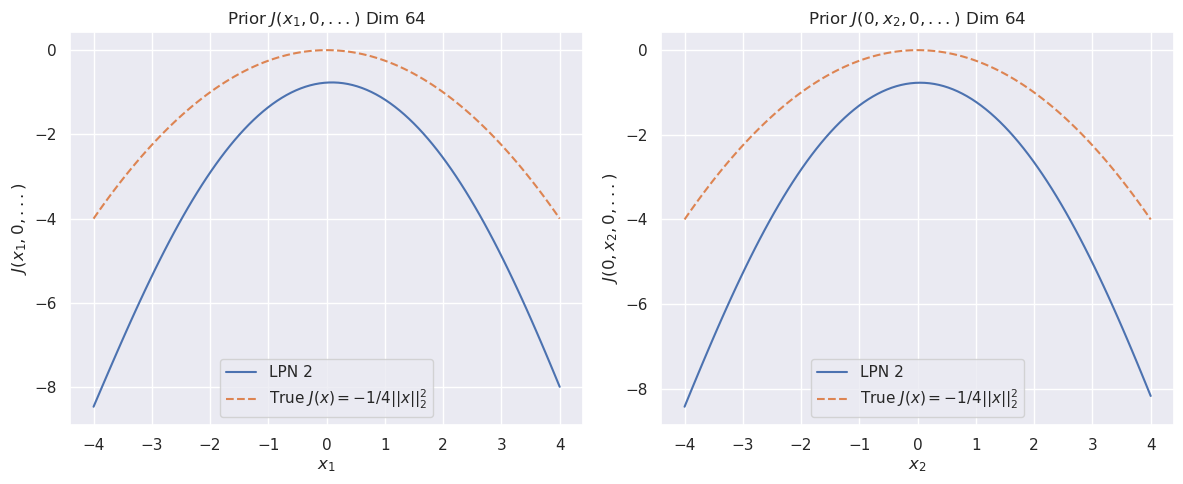

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)